In [17]:
import scipy.optimize
from qutip import *
from itertools import combinations,product
import numpy as np
from functools import partial
import matplotlib
from matplotlib import pyplot as plt
from math import sqrt
from multiprocessing import Pool
from tqdm import tqdm
from time import time
font = {'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 8, 7
plt.rcParams['figure.dpi'] = 70
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

### Non-interacting probability distribution

$$
G(\omega) = \frac{1}{\omega - \epsilon_d - \Sigma_0 + i\Gamma}
$$

At $\Sigma = -\epsilon_d$, this becomes
$$
G(\omega) = \frac{1}{\omega + i\Gamma} \implies \rho_0 = \frac{1}{\pi} \frac{\Gamma^2}{\omega^2 + \Gamma^2}
$$

In [18]:
def get_H0_nu(w_range, gamma, sigma_0, ed, U, n):

    def func_proxy(bnu, x):
        sum = 0
        for b in combinations(bnu, n-1):
            prod = 1
            for bi in b:
                prod *= (x-bi)
            sum += prod
        return sum

    def func(bnu, x):
        sum = 0
        for i in bnu:
            sum += 1/(x - i)
        return abs(sum)


    while True:
        try:
            np.random.seed()
            rho = (1/np.pi)*gamma**2/(gamma**2 + (w_range - ed - sigma_0)**2)
            bnu = np.random.choice(w_range, size=n, replace=False, p=rho/sum(rho))
            func_partial = partial(func_proxy, bnu)
            Ek_nu = scipy.optimize.broyden1(func_partial, bnu[:-1], f_tol=1e-10)
            if len(np.unique(Ek_nu)) == n-1:
                break
        except:
            pass
    Vk_nu = []
    for Ek in Ek_nu:
        Vk_nu.append(0)
        for b in combinations(bnu, n-1):
            prod = 1
            for bi in b:
                prod *= (Ek-bi)**2
            Vk_nu[-1] += prod
        Vk_nu[-1] = sqrt(n*Vk_nu[-1])

    e0_nu = np.mean(bnu)
    U_nu = U
    ed_nu = e0_nu - sigma_0
    return e0_nu, Ek_nu, Vk_nu, ed_nu, U_nu

In [19]:
def imp_energy(Ek_0, V, ed, U):
    H = 0
    dim = len(Ek_0)
    H += ed*tensor([create(2)*destroy(2), identity(2)] + [identity(2)]*2*dim)
    H += ed*tensor([identity(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    H += U*tensor([create(2)*destroy(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    return H


def kin_en(Ek_0, V, ed, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        H += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [create(2)*destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), create(2)*destroy(2)] + [identity(2)]*2*(dim - i - 1)))
    return H


def hyb(Ek_0, Vk, ed, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        H += Vk[i] * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1))
        H += Vk[i] * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1))
#         H -= Vk[i] * tensor([destroy(2), identity(2)] + [identity(2)]*2*i + [create(2), identity(2)] + [identity(2)]*2*(dim - i - 1)) 
#         H -= Vk[i] * tensor([identity(2), destroy(2)] + [identity(2)]*2*i + [identity(2), create(2)] + [identity(2)]*2*(dim - i - 1))
    return H + H.dag()


def get_ham(Ek_0, Vk, ed, U):
    H_d = 0
    dim = len(Ek_0)
    H_d += ed*tensor([create(2)*destroy(2), identity(2)] + [identity(2)]*2*dim)
    H_d += ed*tensor([identity(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    H_d += U*tensor([create(2)*destroy(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    H_k = 0
    H_v = 0
    for i in range(dim):
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [create(2)*destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), create(2)*destroy(2)] + [identity(2)]*2*(dim - i - 1)))
        H_v += Vk[i] * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1))
        H_v += Vk[i] * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1))
    return H_d + H_k + H_v + H_v.dag()

In [20]:
def occ_RLM(Ek_0, Vk):
    H_k = 0
    H_v = 0
    dim = len(Ek_0)
    for i in range(dim):
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [create(2)*destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), create(2)*destroy(2)] + [identity(2)]*2*(dim - i - 1)))
        H_v += Vk[i] * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1))
        H_v += Vk[i] * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1))
        
    H = H_k + H_v + H_v.dag()
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    Xgs = X[0]
    cup = [tensor([identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(len(Ek_0) - i)) for i in range(len(Ek_0)+1)]
    cdn = [tensor([identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(len(Ek_0) - i)) for i in range(len(Ek_0)+1)]
    n_up = [c_up.dag()*c_up for c_up in cup]
    n_dn = [c_dn.dag()*c_dn for c_dn in cdn]
    nup = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_up])
    ndn = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_dn])
    return nup+ndn


In [21]:
def G_nu(w_range, E, X, Ek_nu, Vk_nu):
    delta = gamma
    E0 = min(E)
    cup = [tensor([identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(len(Ek_nu) - i)) for i in range(len(Ek_nu)+1)]
    cdn = [tensor([identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(len(Ek_nu) - i)) for i in range(len(Ek_nu)+1)]
    n_up = [c_up.dag()*c_up for c_up in cup]
    n_dn = [c_dn.dag()*c_dn for c_dn in cdn]
    X0 = X[np.where(E == min(E))]
    X0_single = []
    try:
        n_RLM = occ_RLM(Ek_nu, Vk_nu)
    except:
        return [], False
    for Xgs in X0:
        nup = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_up])
        ndn = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_dn])
        if nup+ndn == n_RLM:
            X0_single.append(Xgs)

    if X0_single == []:
#         print ("failed")
        return [], False

    Gnu = 0*w_range
    for (En, Xn), X0_ in product(zip(E,X), X0_single):
        c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(X0_.dims[0])-2))
        C1 = X0_.dag()*c0_up*Xn
        C1_sq = np.real((C1*C1.dag())[0][0][0])
        C2 = Xn.dag()*c0_up*X0_
        C2_sq = np.real((C2*C2.dag())[0][0][0])
        x1 = w_range + E0 - En
        x2 = w_range + En - E0
        Gnu += (delta/np.pi)*(C1_sq/(x1**2 + delta**2) + C2_sq/(x2**2 + delta**2))/len(X0_single)
#         Gnu += C1_sq/x1 + C2_sq/x2
#     print ("succeeded")
    return Gnu, True

def sigma_nu(w_range, Gnu, e0_nu, Vk_nu, Ek_nu, sigma_0):
    G_nu_0_inv = w_range - e0_nu  - sum([Vk**2/(w_range - Ek) for Vk, Ek in zip(Vk_nu, Ek_nu)])
    sigma_nu = G_nu_0_inv - 1/Gnu + sigma_0
    return sigma_nu

100%|██████████| 500/500 [00:53<00:00,  9.38it/s]
0
0.4987493746873435


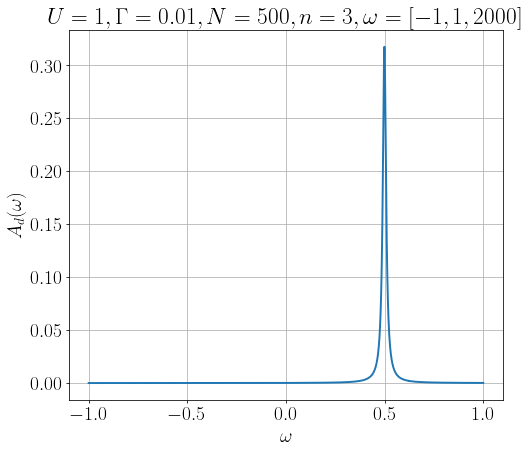

 11%|█         | 54/500 [00:06<00:52,  8.46it/s]Process ForkPoolWorker-87:



KeyboardInterrupt: 

In [26]:
U = 1
ed = -U/2
sigma_0 = U/2   # this needs to be looked into
w_edge = 1
w_num = 2000
w_range = np.linspace(-w_edge, w_edge, w_num)
gamma = 0.01
N = 500
n = 3
sigma = w_range*0
rho = w_range*0

def diag(Ek_nu, Vk_nu, ed_nu, U_nu):
    H = 0
    H = get_ham(Ek_nu, Vk_nu, ed_nu, U_nu)
#     H += kin_en(Ek_nu, Vk_nu, ed_nu, U_nu)
#     H += imp_energy(Ek_nu, Vk_nu, ed_nu, U_nu)
#     H += hyb(Ek_nu, Vk_nu, ed_nu, U_nu)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    return E, X



def sample(i):
#     while True:
    t1 = time()
    e0_nu, Ek_nu, Vk_nu, ed_nu, U_nu = get_H0_nu(w_range, gamma, sigma_0, ed, U, n)
#     print ("1.",time() - t1)
    t2 = time()
    E, X = diag(Ek_nu, Vk_nu, ed_nu, U_nu)
#     print ("2.",time() - t2)
    t3 = time()
    Gnu, flag = G_nu(w_range, E, X, Ek_nu, Vk_nu)
#     print ("3.",time() - t3)
    if flag == False:
        return w_range*0
    sigmanu = sigma_nu(w_range, Gnu, e0_nu, Vk_nu, Ek_nu, sigma_0)/N
    return sigmanu


for i in range(5):
    sigmanu = list(tqdm(Pool(4).imap(sample, range(N)), total=N))
    print (i)
    sigma += sum(sigmanu)/len(sigmanu)
    rho += (1/np.pi)*gamma**2/(gamma**2 + (w_range - ed - sigma)**2)
    print (w_range[np.argmax(rho)])
    plt.plot(w_range, rho)
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$A_d(\omega)$")
    plt.title(r"$U={}, \Gamma = {}, N = {}, n = {}, \omega = [-{}, {}, {}]$".format(U, gamma, N*(i+1), n, w_edge, w_edge,w_num))
#     plt.savefig("A:U={}, \Gamma = {}, N = {}, n = {}, \omega = [-{}, {}, {}].pdf".format(U, gamma, N, n, w_edge, w_edge, w_num), bbox_inches='tight', dpi=600)
    plt.show()
#     plt.plot(w_range, sigma)
#     plt.xlabel(r"$\omega$")
#     plt.ylabel(r"$\Sigma_d(\omega)$")
#     plt.title(r"$U={}, \Gamma = {}, N = {}, n = {}, \omega = [-{}, {}, {}]$".format(U, gamma, N, n, w_edge, w_edge, w_num))
#     plt.savefig("Sigma: U={}, \Gamma = {}, N = {}, n = {}, \omega = [-{}, {}, {}].pdf".format(U, gamma, N, n, w_edge, w_edge, w_num), bbox_inches='tight', dpi=600)
#     plt.show()
